In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, gc, io, math, random, datetime

import statsapi
from utils.load_data import create_df, get_player_stats

#modeling
import statsmodels.api as sm

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report,roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:

teams = statsapi.get('teams',{'sportIds':1,'activeStatus':'Yes','fields':'teams,id,name'})['teams']

## Load in Data

This is a slow brute force method designed simply to pull in stats and create a feature table. 
To create this, all i did was take batters and pitchers stats and add them as a feature for the game. Home and away

In [3]:
if not os.path.exists("./data"):
    os.mkdir("./data")


# load the data if exists else create and save
if not os.path.exists("./data/games2023.tsv"):
    games2023_df = create_df(teams,2023)
    games2023_df = get_player_stats(games2023_df)
    games2023_df.to_csv("./data/games2021.tsv", sep="\t")
    print('created')
else:
    games2023_df = pd.read_csv("./data/games2023.tsv", sep="\t")
    print('loaded')


if not os.path.exists("./data/games2022.tsv"):
    games2022_df = create_df(teams,2022)
    games2022_df = get_player_stats(games2022_df)
    games2022_df.to_csv("./data/games2022.tsv", sep="\t")
    print('created')
else:
    games2022_df = pd.read_csv("./data/games2022.tsv", sep="\t")
    print('loaded')

# load the data if exists else create and save
if not os.path.exists("./data/games2021.tsv"):
    games2021_df = create_df(teams,2021)
    games2021_df = get_player_stats(games2021_df)
    games2021_df.to_csv("./data/games2021.tsv", sep="\t")
    print('created')
else:
    games2021_df = pd.read_csv("./data/games2021.tsv", sep="\t")
    print('loaded')

if not os.path.exists("./data/games2020.tsv"):
    games2020_df = create_df(teams,2020)
    games2020_df = get_player_stats(games2020_df)
    games2020_df.to_csv("./data/games2020.tsv", sep="\t")
    print('created')
else:
    games2020_df = pd.read_csv("./data/games2020.tsv", sep="\t")
    print('loaded')

loaded
loaded
loaded
loaded


#### Quick extras we can look at

In [4]:
games2022_df['run_diff'] = games2022_df['home_score'].astype(int) - games2022_df['away_score'].astype(int)
games2022_df['home_win'] = games2022_df['run_diff'].apply(lambda x: True if x>0 else False)
cols = [i for i in games2022_df.columns if 'batter' in i or 'pitcher_' in i]

## Regression Models

Regression is likley the best way to handle such crude data. 

The function for each feature is 1/(1+e^-x). As such every feature is smaller than one and the inverse of this is equal to the slope relative to the curve so it shows us how much more likely you are to win if your BA increases by .001 etc

In [5]:
X = games2022_df[cols]
y = games2022_df['home_win']


## This cleans up the cols. Pitchers with no data get a 6.00 era.
def clean_up_cols(df,fill=6.00):
    try:
        df = df.drop(columns=['away_pitcher_5','home_pitcher_5'])
    except:
        pass
    miss = []

    for col in df.columns:
        for i in df.index:
            try:
                df.loc[i,col] = float(df.loc[i,col])
            except:
                miss.append([i,col])

    for i in miss:
        df.loc[i[0],i[1]] = fill

    df = df.astype(float)

    for col in df.columns:
        df[col] = df[col].fillna(df[col].median())

    return df

X = clean_up_cols(X)
X['intercept'] = 1

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=819)
model = sm.Logit(y_train,X_train).fit()

Optimization terminated successfully.
         Current function value: 0.608112
         Iterations 6


### This is a likelihood table for the features used here

In [6]:
model_table = pd.read_html(model.summary().tables[1].as_html(), header=0,index_col=0)[0]
model_table['likelihood'] = np.exp(model_table['coef'])/1000
model_table_hitters = model_table.iloc[:18]
model_table_pitchers = model_table.iloc[18:]
model_table_pitchers['likelihood']= model_table_pitchers['likelihood'] * 10

model_table

C:\Users\batuu\AppData\Local\Temp\ipykernel_10140\1751538844.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_table_pitchers['likelihood']= model_table_pitchers['likelihood'] * 10


,coef,std err,z,P>|z|,[0.025,0.975],likelihood
away_batter_1,-0.1371,0.606,-0.226,0.821,-1.324,1.050,0.000872
away_batter_2,-0.9618,0.567,-1.695,0.090,-2.074,0.150,0.000382
away_batter_3,0.0444,0.566,0.079,0.937,-1.064,1.153,0.001045
away_batter_4,0.1610,0.567,0.284,0.776,-0.950,1.272,0.001175
away_batter_5,-0.0464,0.535,-0.087,0.931,-1.095,1.002,0.000955
away_batter_6,0.4020,0.505,0.795,0.426,-0.589,1.393,0.001495
away_batter_7,-0.2971,0.463,-0.642,0.521,-1.205,0.611,0.000743
away_batter_8,-0.1663,0.462,-0.360,0.719,-1.071,0.739,0.000847
away_batter_9,-0.5269,0.411,-1.280,0.200,-1.333,0.280,0.000590
home_batter_1,0.4835,0.650,0.744,0.457,-0.790,1.757,0.001622


## Classification of the results.

We can now take the model results and use them to predict the games directly. A straight prediction will use a cut off in the center of the curve. 

In [7]:
preds = model.predict(X_test)
binary_preds = list(map(round, preds)) 

#classification
print(classification_report(y_test,binary_preds))

#ROC
roc = roc_auc_score(y_test,preds)
fpr, tpr, _ = roc_curve(y_test,  preds)
print('ROC AUC: {}'.format(roc))

              precision    recall  f1-score   support

       False       0.68      0.63      0.66       484
        True       0.68      0.73      0.70       525

    accuracy                           0.68      1009
   macro avg       0.68      0.68      0.68      1009
weighted avg       0.68      0.68      0.68      1009

ROC AUC: 0.7583844942935852


## We can repeat this for the 2023 data as well 

In [8]:
games2023_df['run_diff'] = games2023_df['home_score'].astype(int) - games2023_df['away_score'].astype(int)
games2023_df['home_win'] = games2023_df['run_diff'].apply(lambda x: True if x>0 else False)

X1 = games2023_df[cols]
y1 = games2023_df['home_win']

#pipeline cleaning LOL
X1 = clean_up_cols(X1)

X1 = pd.DataFrame(MinMaxScaler().fit_transform(X1), index=X1.index, columns=X1.columns)
X1['intercept'] = 1
#train test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1, test_size=.2, random_state=819)
model2023 = sm.Logit(y1_train,X1_train).fit()

#make the predictions
preds23 = model2023.predict(X1_test)
binary_preds23 = list(map(round, preds23)) 

#print data
print(classification_report(y1_test,binary_preds23))

#ROC
roc2 = roc_auc_score(y1_test,preds23)
fpr2, tpr2, _ = roc_curve(y1_test,  preds23)
print('ROC AUC: {}'.format(roc2))

Optimization terminated successfully.
         Current function value: 0.604898
         Iterations 7
              precision    recall  f1-score   support

       False       0.72      0.65      0.69       513
        True       0.68      0.74      0.71       499

    accuracy                           0.70      1012
   macro avg       0.70      0.70      0.70      1012
weighted avg       0.70      0.70      0.70      1012

ROC AUC: 0.7742522081199437


## Lets combine those years 

In [9]:
#pipeline cleaning LOL
Xc = pd.concat([X,X1])
yc = pd.concat([y,y1])

#train test split
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc,yc, test_size=.2, random_state=819)
modelComb = sm.Logit(yc_train,Xc_train).fit()

#make the predictions
predsComb = modelComb.predict(Xc_test)
binary_predsComb = list(map(round, predsComb)) 

#print data
print(classification_report(yc_test,binary_predsComb))

#ROC
rocComb = roc_auc_score(yc_test,predsComb)
fprComb, tprComb, _ = roc_curve(yc_test,  predsComb)
print('ROC AUC: {}'.format(rocComb))

Optimization terminated successfully.
         Current function value: 0.642553
         Iterations 6
              precision    recall  f1-score   support

       False       0.65      0.55      0.60       990
        True       0.62      0.72      0.67      1031

    accuracy                           0.64      2021
   macro avg       0.64      0.63      0.63      2021
weighted avg       0.64      0.64      0.63      2021

ROC AUC: 0.6978862338222183


## We can use 2021 in its enirety as an out group here

This tells us how these basic models perform outside the dataset. We can assume leakage

In [10]:
games2021_df['run_diff'] = games2021_df['home_score'].astype(int) - games2021_df['away_score'].astype(int)
games2021_df['home_win'] = games2021_df['run_diff'].apply(lambda x: True if x>0 else False)

X_out = games2021_df[cols]
y_out = games2021_df['home_win']
X_out = clean_up_cols(X_out)
X_out['intercept'] = 1

In [11]:

preds22 = model.predict(X_out)
auc22 = roc_auc_score(y_out,preds22)
fpr22, tpr22, _ = roc_curve(y_out,  preds22)

preds23 = model2023.predict(X_out)
auc23 = roc_auc_score(y_out,preds23)
fpr23, tpr23, _ = roc_curve(y_out,  preds23)

preds_c = modelComb.predict(X_out)
auc_c = roc_auc_score(y_out,preds_c)
fpr_c, tpr_c, _ = roc_curve(y_out,  preds_c)

c:\Users\batuu\anaconda3\envs\pythonProject\lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


# Validation: 

## Plot those curves externally AND internally

We can compare to see if the models lose value

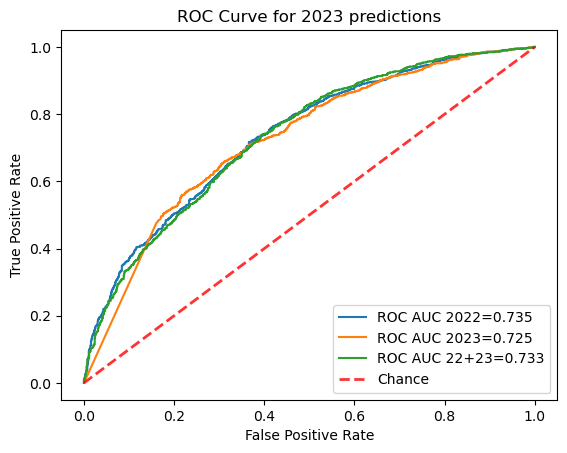

In [12]:
fig,ax = plt.subplots()
plt.plot(fpr22,tpr22,label="ROC AUC 2022="+ '{:.3f}'.format(auc22))
plt.plot(fpr23,tpr23,label="ROC AUC 2023="+'{:.3f}'.format(auc23))
plt.plot(fpr_c,tpr_c,label="ROC AUC 22+23="+'{:.3f}'.format(auc_c))

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC Curve for 2023 predictions')
plt.show()

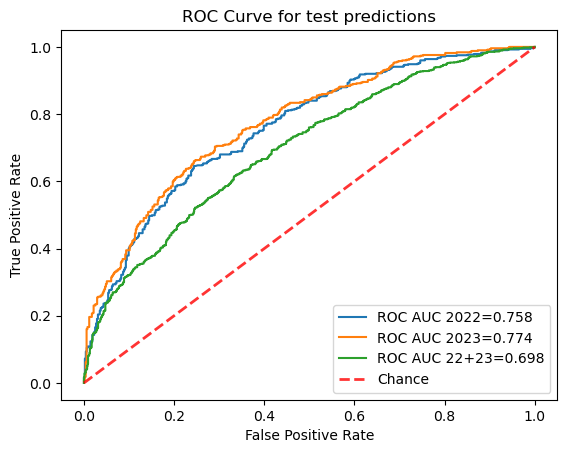

In [13]:
fig,ax = plt.subplots()
plt.plot(fpr,tpr,label="ROC AUC 2022="+ '{:.3f}'.format(roc))
plt.plot(fpr2,tpr2,label="ROC AUC 2023="+'{:.3f}'.format(roc2))
plt.plot(fprComb,tprComb,label="ROC AUC 22+23="+'{:.3f}'.format(rocComb))

ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC Curve for test predictions')
plt.show()

## Application

So we have validated this model and we can see its actually not horrible relative to the 2021 season. This is with very little effort to get great data. So we can say just with these raw stats, with little thought, we have significant predictive power relative to an entire season.

Its important to remember our assumptions with such a model.
1) every game is independent
2) player performance is fixed to their overall stats
3) no external factors matter
4) we can weigh pitching and hitting equally
5) fielding is independent of results
6) every player and pitcher is independent

Our intercept is ASSUMED to be the correction for this. This is probably not true though

That said we can use this model, get todays games, get the games from this season those far and try it

In [14]:
current = datetime.datetime.now()
current_date = current.strftime('%m/%d/%Y')
rosters = {}

today_games = statsapi.schedule(date=current_date)

predicted_games = pd.DataFrame(today_games)


predicted_games = get_player_stats(predicted_games, previous=True)
predicted_games = clean_up_cols(predicted_games[cols])
predicted_games['intercept'] = 1

today_predictions = model.predict(predicted_games)

today_df = pd.DataFrame(today_games)
today_df['home_win'] = today_predictions
today_df['home_win_pct'] = (today_df['home_win'] *100).round(2)



winner = lambda x,y,z: x if z>= 0.5 else y

game_log = pd.DataFrame()
for i,r in today_df.iterrows():
    #print(f"{r['away_name']} @ {r['home_name']}:\tHome team has a {r['home_win_pct']} chance. Winner: {winner(r['home_name'],r['away_name'], r['home_win'])}")
    game_log.loc[i,['matchup','home_win%','winner']] = f"{r['away_name']} @ {r['home_name']}",r['home_win_pct'],winner(r['home_name'],r['away_name'], r['home_win'])

display(game_log)

,matchup,home_win%,winner
0,Oakland Athletics @ Detroit Tigers,86.26,Detroit Tigers
1,Cleveland Guardians @ Minnesota Twins,47.12,Cleveland Guardians
2,Miami Marlins @ St. Louis Cardinals,94.29,St. Louis Cardinals
3,Los Angeles Dodgers @ Chicago Cubs,72.47,Chicago Cubs
4,Baltimore Orioles @ Pittsburgh Pirates,31.22,Baltimore Orioles
5,Philadelphia Phillies @ Washington Nationals,81.52,Washington Nationals
6,New York Mets @ Cincinnati Reds,19.55,New York Mets
7,Houston Astros @ Texas Rangers,71.60,Texas Rangers
8,Toronto Blue Jays @ New York Yankees,53.30,New York Yankees
9,Chicago White Sox @ Kansas City Royals,7.38,Chicago White Sox


## Results

The model works, however it quickly shows the limitations of such a rudimentaty method because it fails to generalize to the early season lack of data and makes extreme predictions